Задания:

- Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
- Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
- Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS
Дополнительно

- Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, 
- подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
- Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
kobe = pd.read_csv('Kobe.csv')
kobe = kobe[~np.isnan(kobe['shot_made_flag'])] # убераем занчения Nan
kobe = kobe[kobe['shot_distance']<=25] # баскетбольная площадка имеет размер 25х15 метров, убираем некорректные данные
kobe['shot_made_flag'] = kobe['shot_made_flag'].astype('int64')

kobe['sum_flag_per_dist'] = kobe.groupby('shot_distance')['shot_made_flag'].transform(lambda x: x.sum())
kobe['sum_shots_per_dist'] = kobe.groupby('shot_distance')['shot_made_flag'].transform(lambda x: x.count())

kobe['sum_flag_per_min'] = kobe.groupby('minutes_remaining')['shot_made_flag'].transform(lambda x: x.sum())
kobe['sum_shots_per_min'] = kobe.groupby('minutes_remaining')['shot_made_flag'].transform(lambda x: x.count())

kobe['sum_flag_per_opponent'] = kobe.groupby('opponent')['shot_made_flag'].transform(lambda x: x.sum())
kobe['sum_shots_per_opponent'] = kobe.groupby('opponent')['shot_made_flag'].transform(lambda x: x.count())

kobe['sum_flag_per_action'] = kobe.groupby('action_type')['shot_made_flag'].transform(lambda x: x.sum())
kobe['sum_shots_per_action'] = kobe.groupby('action_type')['shot_made_flag'].transform(lambda x: x.count())

kobe['sum_flag_per_period'] = kobe.groupby('period')['shot_made_flag'].transform(lambda x: x.sum())
kobe['sum_shots_per_period'] = kobe.groupby('period')['shot_made_flag'].transform(lambda x: x.count())

kobe['sum_flag_per_zone'] = kobe.groupby('shot_zone_area')['shot_made_flag'].transform(lambda x: x.sum())
kobe['sum_shots_per_zone'] = kobe.groupby('shot_zone_area')['shot_made_flag'].transform(lambda x: x.count())

kobe = kobe.drop(columns = ['game_date','season','opponent','matchup'])
kobe.head(1)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,shot_id,sum_flag_per_dist,sum_shots_per_dist,sum_flag_per_min,sum_shots_per_min,sum_flag_per_opponent,sum_shots_per_opponent,sum_flag_per_action,sum_shots_per_action,sum_flag_per_period,sum_shots_per_period,sum_flag_per_zone,sum_shots_per_zone
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,22,15,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2,415,972,790,1719,580,1207,4677,13967,3017,6334,1243,3132


In [4]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

cols=['shot_type',
 'action_type',
 'combined_shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_name']

kobe = get_one_hot(
        kobe,
        cols
    )

kobe = kobe.drop( labels=cols, axis=1)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(kobe, kobe["shot_made_flag"]):
    strat_train_set = kobe.iloc[train_index]
    strat_test_set = kobe.iloc[test_index]

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

sum_flag_per_dist_ix, sum_shots_per_dist_ix, sum_flag_per_min_ix, sum_shots_per_min_ix, \
sum_flag_per_opponent_ix, sum_shots_per_opponent_ix, sum_flag_per_action_ix, sum_shots_per_action_ix, \
sum_flag_per_period_ix, sum_shots_per_period_ix, sum_flag_per_zone_ix, \
sum_shots_per_zone_ix = 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self  
    def transform(self, X, y=None):
        accuracy_distance = X[:, sum_shots_per_dist_ix] / X[:, sum_flag_per_dist_ix]
        accuracy_minutes = X[:, sum_shots_per_min_ix] / X[:, sum_flag_per_min_ix]
        accuracy_opponent = X[:, sum_shots_per_opponent_ix] / X[:, sum_flag_per_opponent_ix]
        accuracy_action = X[:, sum_shots_per_action_ix] / X[:, sum_flag_per_action_ix]
        accuracy_period = X[:, sum_shots_per_period_ix] / X[:, sum_flag_per_period_ix]
        accuracy_zone = X[:, sum_shots_per_zone_ix] / X[:, sum_flag_per_zone_ix]
        return np.c_[X, accuracy_distance, accuracy_minutes, accuracy_opponent, accuracy_period, accuracy_zone]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [7]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer
strat_train_set.reset_index()

num_attribs = strat_train_set.columns.copy()
num_attribs = num_attribs.drop(['shot_made_flag'])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
])

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
X_train = strat_train_set.drop("shot_made_flag", axis=1)
y_train = strat_train_set["shot_made_flag"].copy()

X_test = strat_test_set.drop("shot_made_flag", axis=1)
y_test = strat_test_set["shot_made_flag"].copy()


In [9]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [10]:
columns = num_attribs.copy()
columns = columns.append(pd.Index(['accuracy_distance', 'accuracy_minutes', 'accuracy_opponent', \
                                   'accuracy_period', 'accuracy_zone','shot_made_flag']))
columns = [ i.replace(".","") for i in columns ]
columns = [ i.replace(" ","_") for i in columns ]
columns = [ i.replace("@","at") for i in columns ]
columns = [ i.replace("+","plus") for i in columns ]
columns = [ i.replace("(","_") for i in columns ]
columns = [ i.replace(")","_") for i in columns ]
columns = [ i.replace("-","_") for i in columns ]

In [149]:
a = np.c_[X_train_prepared, y_train]
train_df = pd.DataFrame(a, columns = columns)
test_df = pd.DataFrame(np.c_[X_test_prepared, y_test], columns=columns)

In [156]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

_iteration_cols = train_df.columns.drop('shot_made_flag')

def get_formula(_cols):
    return 'shot_made_flag ~ ' + " + ".join(_cols)

In [157]:
f = get_formula(_iteration_cols)
lm = smf.ols(f, train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.4589051792321079
R^2: 0.15220854659002847


In [158]:
lm_res = lm.summary()
lm_res.tables[1]

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4465,0.009,47.998,0.000,0.428,0.465
game_event_id,0.0329,0.021,1.578,0.115,-0.008,0.074
game_id,0.0509,0.012,4.243,0.000,0.027,0.074
lat,1.482e+10,1.42e+11,0.104,0.917,-2.64e+11,2.94e+11
loc_x,-1.8e+11,9.71e+10,-1.853,0.064,-3.7e+11,1.04e+10
loc_y,1.482e+10,1.42e+11,0.104,0.917,-2.64e+11,2.94e+11
lon,1.8e+11,9.71e+10,1.853,0.064,-1.04e+10,3.7e+11
minutes_remaining,0.0084,0.010,0.860,0.390,-0.011,0.027
period,-0.0393,0.020,-2.005,0.045,-0.078,-0.001
playoffs,-0.0225,0.009,-2.388,0.017,-0.041,-0.004


In [137]:
xdf = train_df.copy()
y = xdf['shot_made_flag']
xdf.drop(columns = ['shot_made_flag'])
X = xdf.values

In [262]:
columns_to_plot =  {'minutes_remaining': 231, 'playoffs': 232, 'shot_distance':233, 'shot_id':234, 'game_event_id':235}

In [264]:
ind = [i for i in columns_to_plot]
col = ['rss', 'intercept'] + list(columns_to_plot.keys())
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

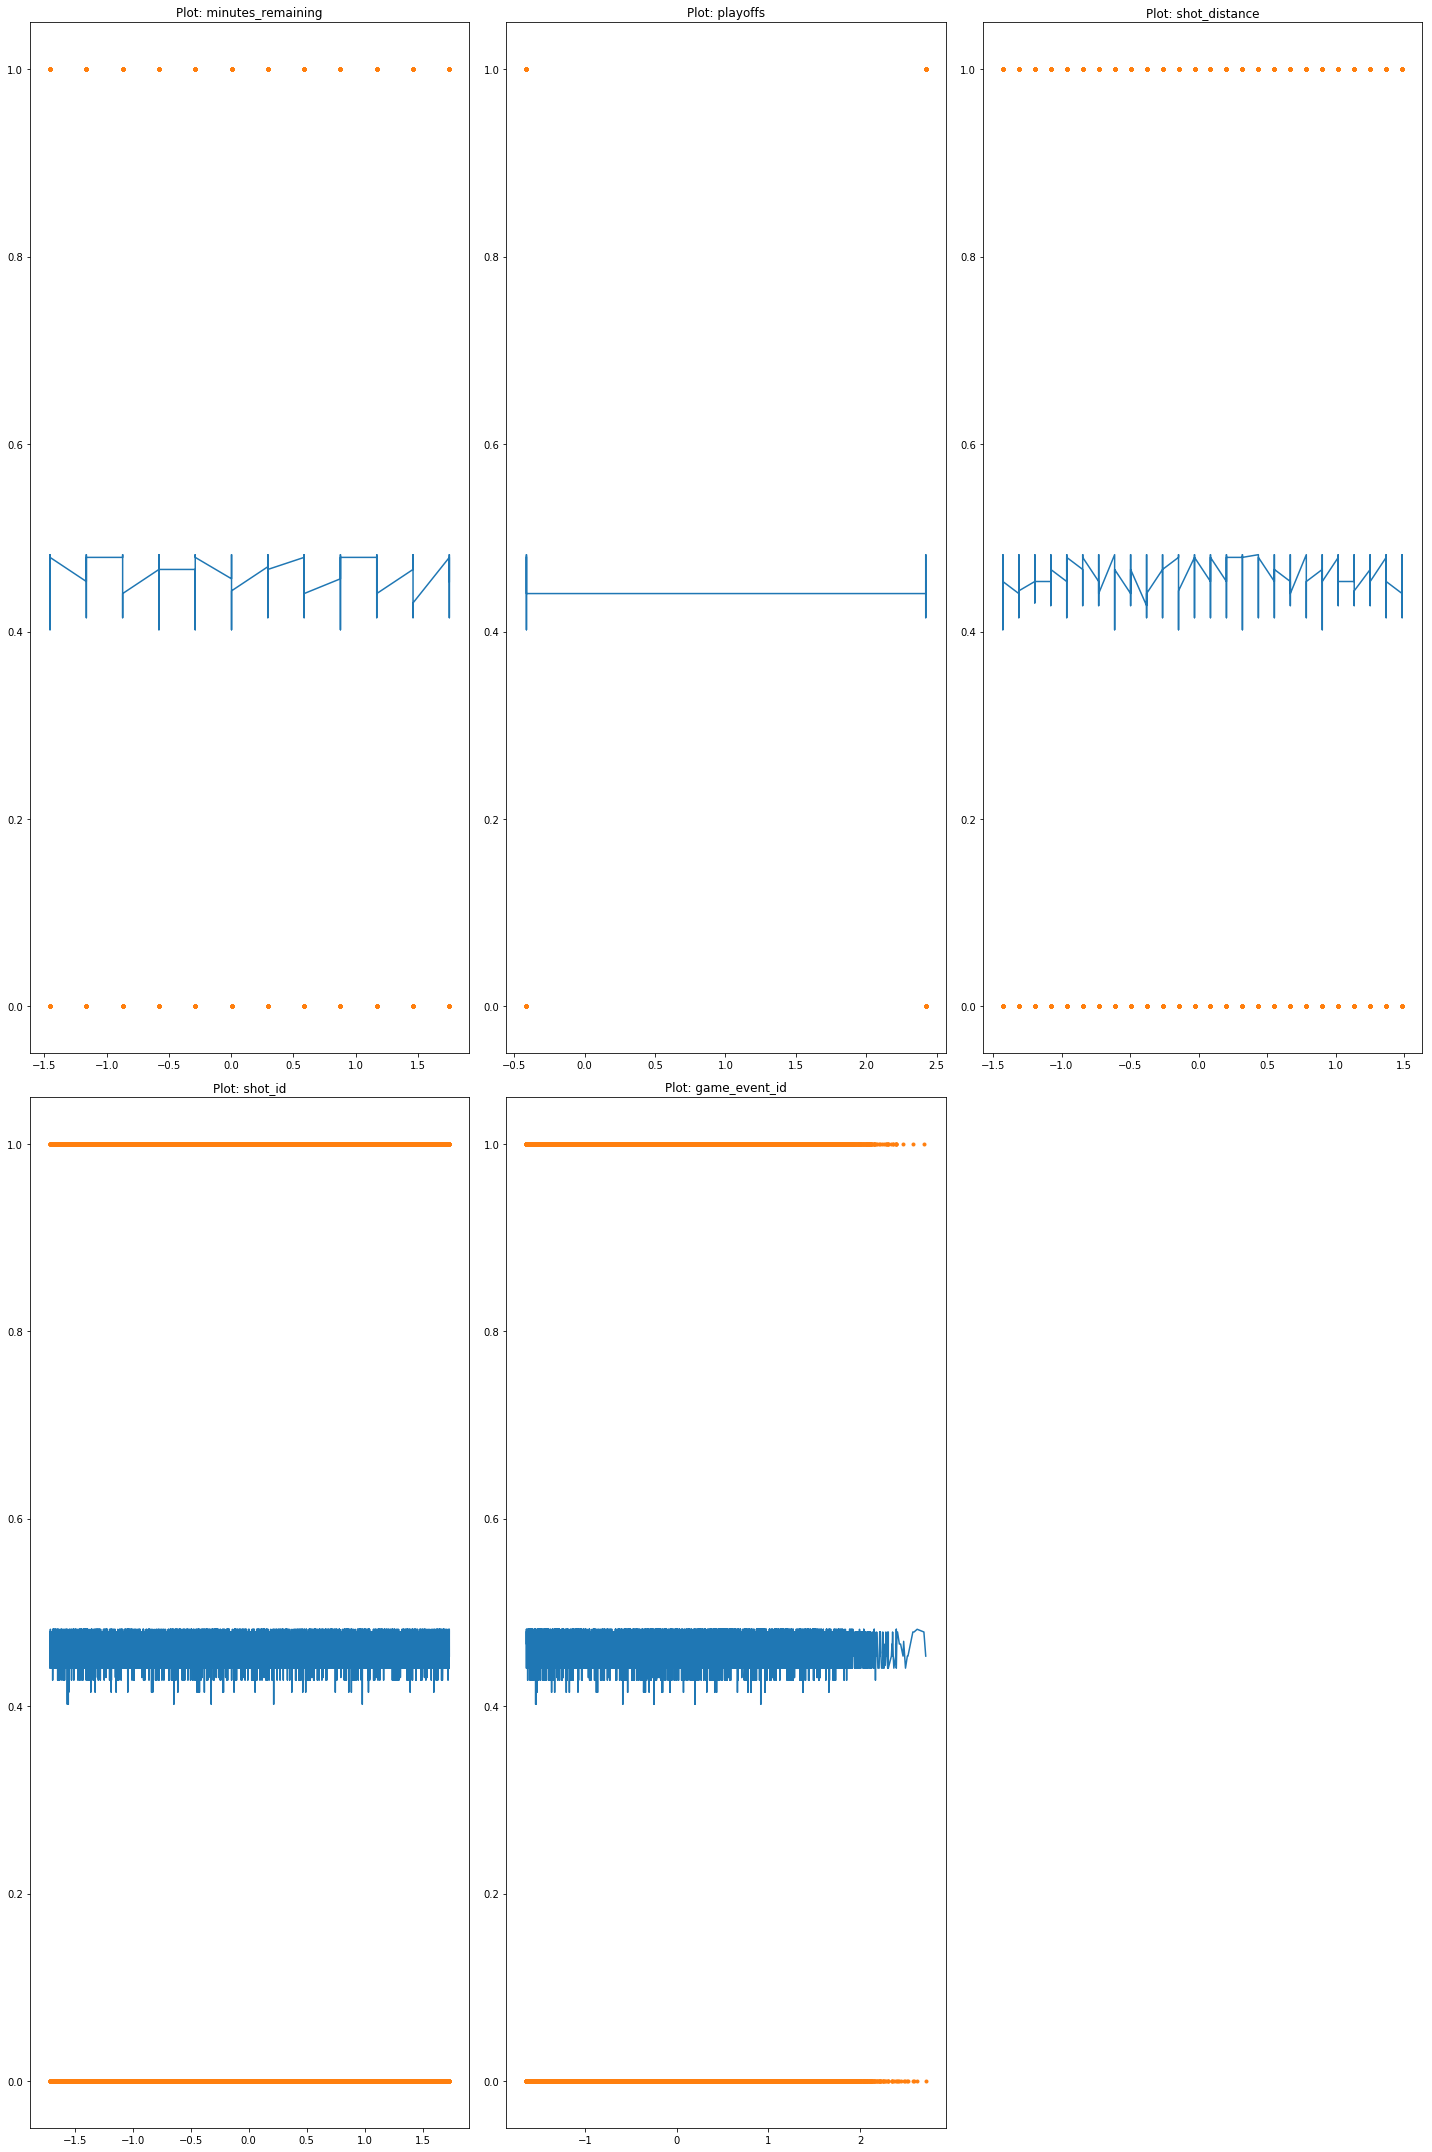

In [268]:
# Отобразить графически не получается :(

from sklearn.linear_model import LinearRegression, Ridge, Lasso

for col in columns_to_plot:
    cols = list(columns_to_plot.keys())
    i = cols.index(col)
    predictors = (train_df[cols[:i+1]])
    
    train_df=train_df.sort_values(by=[col])

    lm = LinearRegression(normalize=True).fit(predictors, train_df['shot_made_flag'])

    # fit
    #linreg.fit(data[predictors], data['y'])
    # models to plot

    plt.subplot(columns_to_plot[col])
    plt.tight_layout()
    plt.plot(train_df[col], y_pred)
    plt.plot(train_df[col], train_df['shot_made_flag'], '.')
    plt.title('Plot: %s' % col)

    # Return the result in pre-defined format
    rss = sum((y_pred - train_df['shot_made_flag']) ** 2)
    ret = [rss]
    ret.extend([lm.intercept_])
    ret.extend(lm.coef_)
       
    coef_matrix_simple.iloc[i, 0:i+3 ] = ret

In [269]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,minutes_remaining,playoffs,shot_distance,shot_id,game_event_id
minutes_remaining,4.7e+03,0.46,-0.0044,NaN,NaN,NaN,NaN
playoffs,4.7e+03,0.46,-0.0002,-0.0026,NaN,NaN,NaN
shot_distance,4.7e+03,0.46,0.026,-0.041,0.0011,NaN,NaN
shot_id,4.7e+03,0.46,-0.0045,-0.0036,-0.0029,0.0014,NaN
game_event_id,4.7e+03,0.46,0.0056,-0.011,0.00027,-0.0069,0.0012


In [270]:
rg = Ridge(alpha=1000).fit(X, y)
print(rg.intercept_)

0.09143102360264321


In [271]:
rg = Lasso().fit(X, y)
print(rg.intercept_)

0.4600378588705437


In [142]:
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
y_test_predict = xgb.predict_proba(X_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.78
Test:  0.7


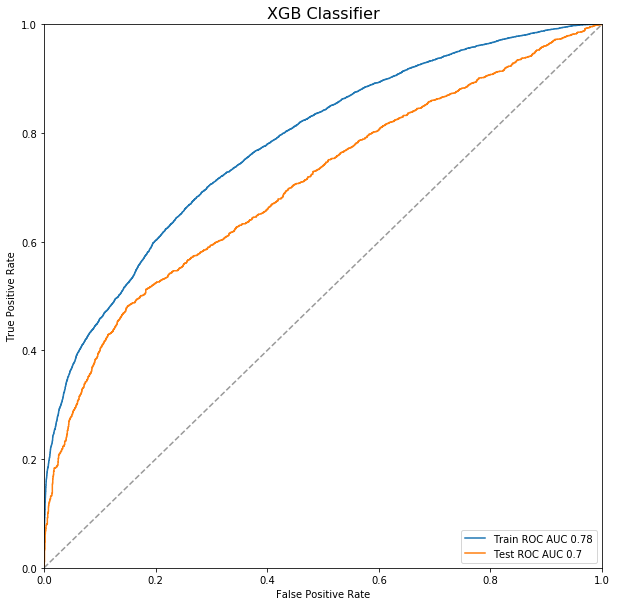

In [143]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

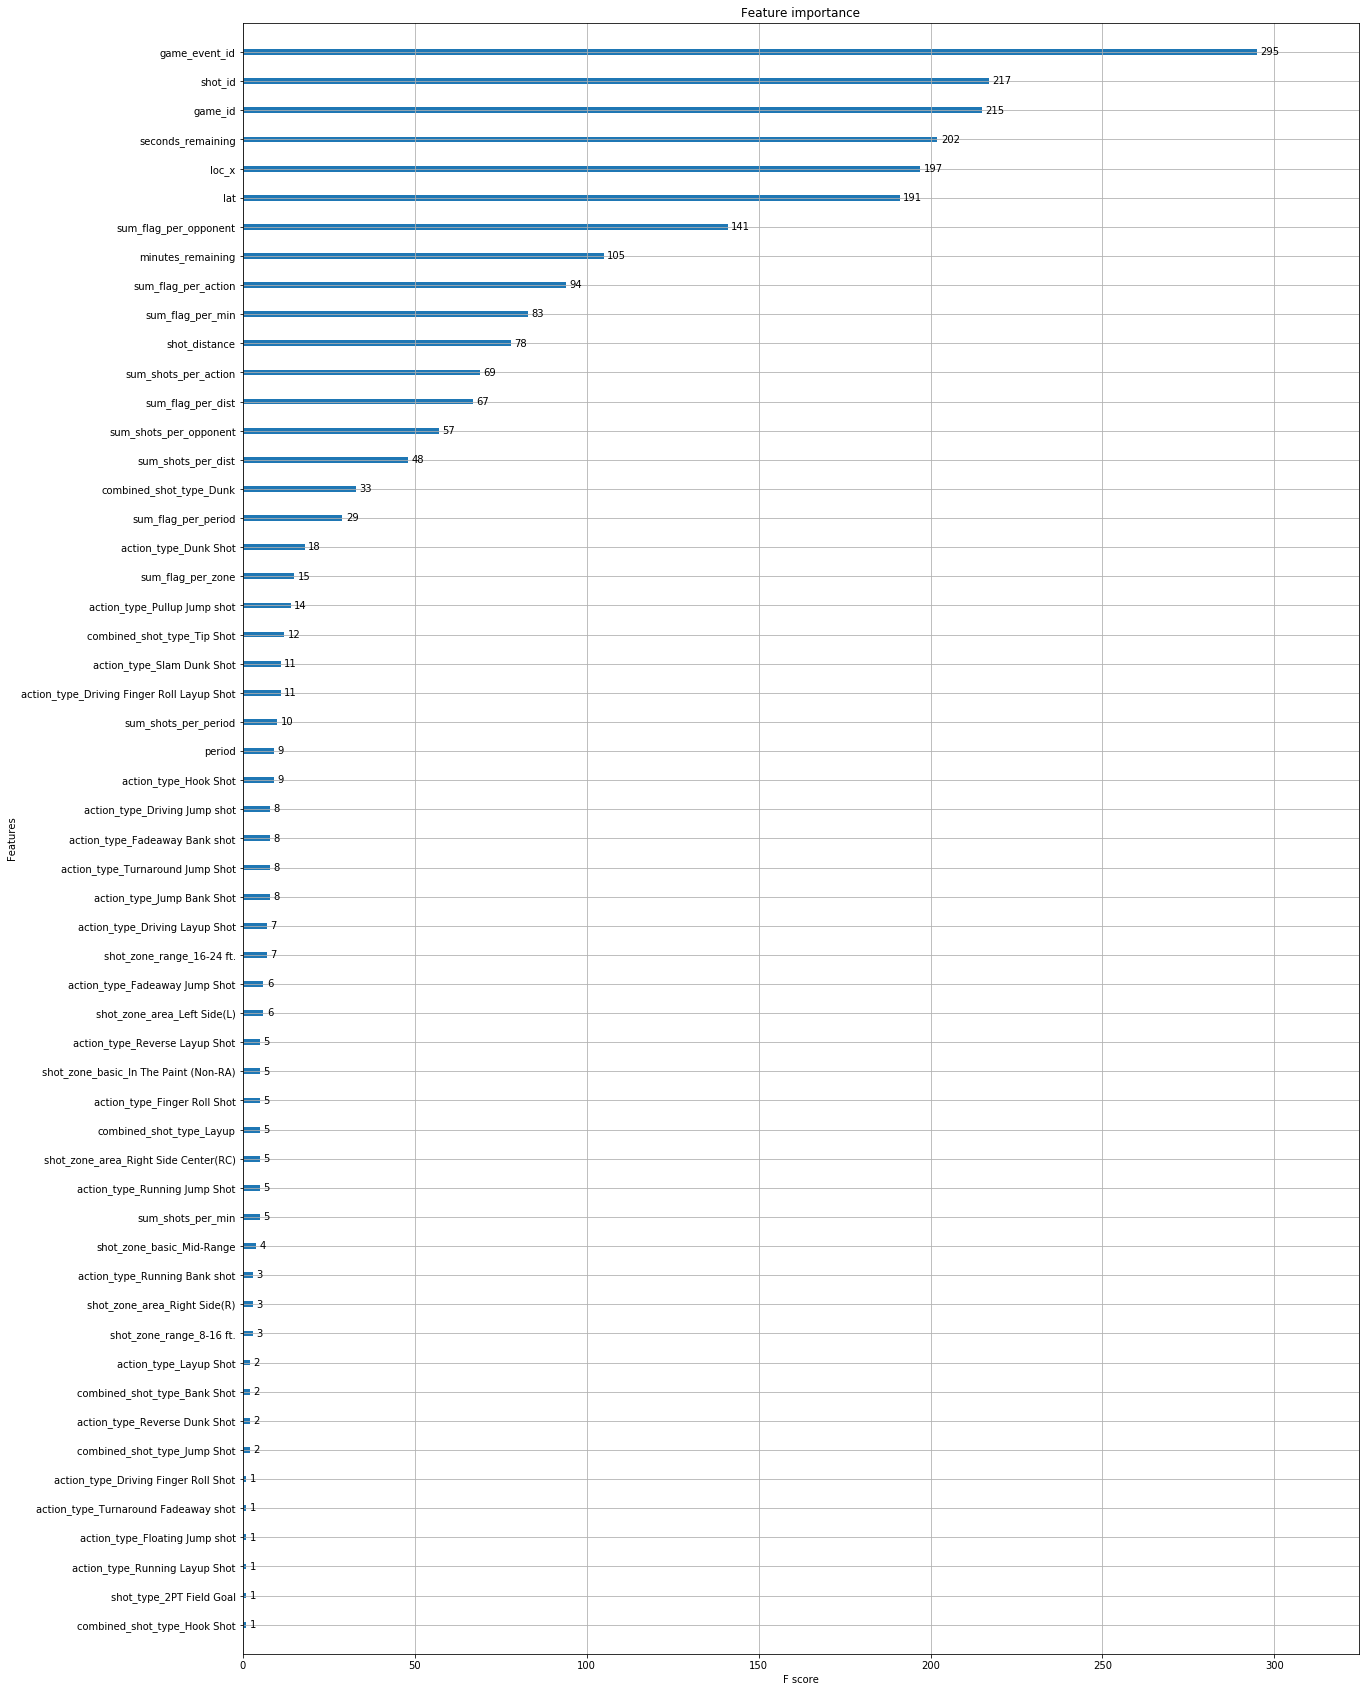

In [144]:
matplotlib.rcParams['figure.figsize'] = (20, 30)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')